In [ ]:
#import libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [ ]:
df = pd.read_csv('creditcard.csv')

In [ ]:
df2= df.drop(['Time'],axis=1)

In [ ]:
xtrain,xtest=train_test_split(df2,test_size=0.2,random_state=27)

xtrain = xtrain[xtrain.Class == 0]


In [ ]:
xtrain=xtrain.drop(['Class'],axis=1)
ytest=xtest['Class']
xtest=xtest.drop(['Class'],axis=1)

In [ ]:
mean = xtrain.mean(axis=0)
std = xtrain.std(axis=0)
xtrain=(xtrain-mean)/std
xtest=(xtest-mean)/std

In [ ]:
xtrain=xtrain.to_numpy()
xtest=xtest.to_numpy()
ytest=ytest.to_numpy()

In [ ]:
from tensorflow.keras.layers import Input , Dense
from tensorflow.keras.models import Model

In [ ]:
#Encoder
latent_dim=5
original_dim=29
intermid1=20
intermid2=10
batch_size=64

In [ ]:
input_layer = Input(shape=(original_dim,))
dense1=Dense(intermid1,activation='tanh')(input_layer)
dense2=Dense(intermid2,activation='relu')(dense1)
dense3=Dense(latent_dim,activation='relu')(dense2)
encoder = Model(input_layer,dense3)
encoder.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 29)]              0         
                                                                 
 dense_39 (Dense)            (None, 20)                600       
                                                                 
 dense_40 (Dense)            (None, 10)                210       
                                                                 
 dense_41 (Dense)            (None, 5)                 55        
                                                                 
Total params: 865 (3.38 KB)
Trainable params: 865 (3.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Decoder

In [ ]:
decoder_input=Input(shape=5)
decoder1=Dense(10,activation='relu')(decoder_input)
decoder2=Dense(20,activation='relu')(decoder1)
decoder3=Dense(29,activation='tanh')(decoder2)
decoder=Model(decoder_input,decoder3)
decoder.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_42 (Dense)            (None, 10)                60        
                                                                 
 dense_43 (Dense)            (None, 20)                220       
                                                                 
 dense_44 (Dense)            (None, 29)                609       
                                                                 
Total params: 889 (3.47 KB)
Trainable params: 889 (3.47 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#AutoEncoder

In [ ]:
output= decoder(encoder(input_layer))
autoencoder = Model(input_layer,output)
autoencoder.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 29)]              0         
                                                                 
 model_20 (Functional)       (None, 5)                 865       
                                                                 
 model_21 (Functional)       (None, 29)                889       
                                                                 
Total params: 1754 (6.85 KB)
Trainable params: 1754 (6.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#model compile

In [ ]:
autoencoder.compile(optimizer='adam',loss='mean_squared_error',metrics=['Accuracy'])
history=autoencoder.fit(xtrain,xtrain,epochs=3,batch_size=64,
                      shuffle=True,validation_data=(xtest,xtest),verbose=1).history

Epoch 1/3
3561/3561 [==============================] - 7s 2ms/step - loss: 0.7819 - Accuracy: 0.2172 - val_loss: 0.7129 - val_Accuracy: 0.2558
Epoch 2/3
3561/3561 [==============================] - 6s 2ms/step - loss: 0.6879 - Accuracy: 0.2678 - val_loss: 0.6780 - val_Accuracy: 0.2908
Epoch 3/3
3561/3561 [==============================] - 7s 2ms/step - loss: 0.6640 - Accuracy: 0.2941 - val_loss: 0.6605 - val_Accuracy: 0.3008


In [ ]:


##########################################
# prediction & reconstruction error
##########################################
predictions = autoencoder.predict(xtest)
mse = np.mean(np.power(xtest - predictions, 2), axis=1)

error_df_true=error_df[(error_df['true_class']==0)]


error_df_false=error_df[(error_df['true_class']==1)]

1781/1781 [==============================] - 2s 986us/step


In [ ]:
from sklearn.metrics import confusion_matrix

<AxesSubplot:>

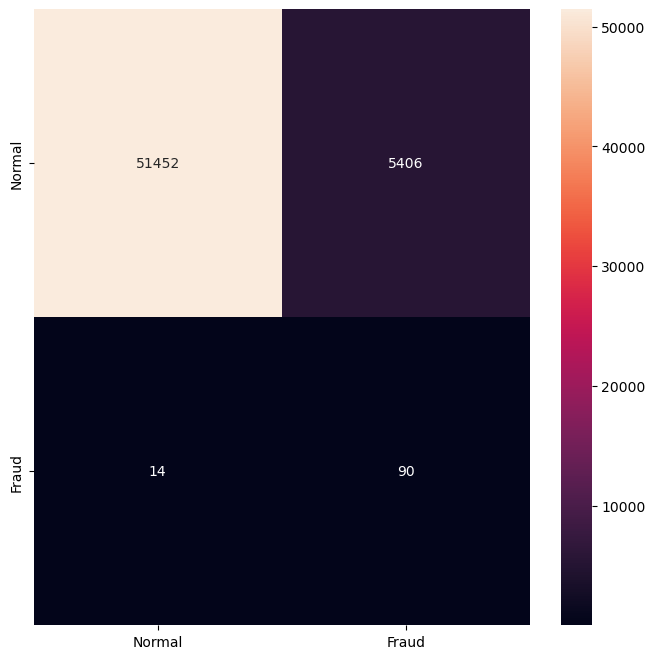

In [ ]:
threshold = 0.9
LABELS=["Normal","Fraud"]
groups= error_df.groupby('true_class')
ypred=[1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
confu_matrix=confusion_matrix(error_df.true_class,ypred)
plt.figure(figsize=(8,8))
sns.heatmap(confu_matrix,xticklabels=LABELS,yticklabels=LABELS,annot=True,fmt="d")

In [ ]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

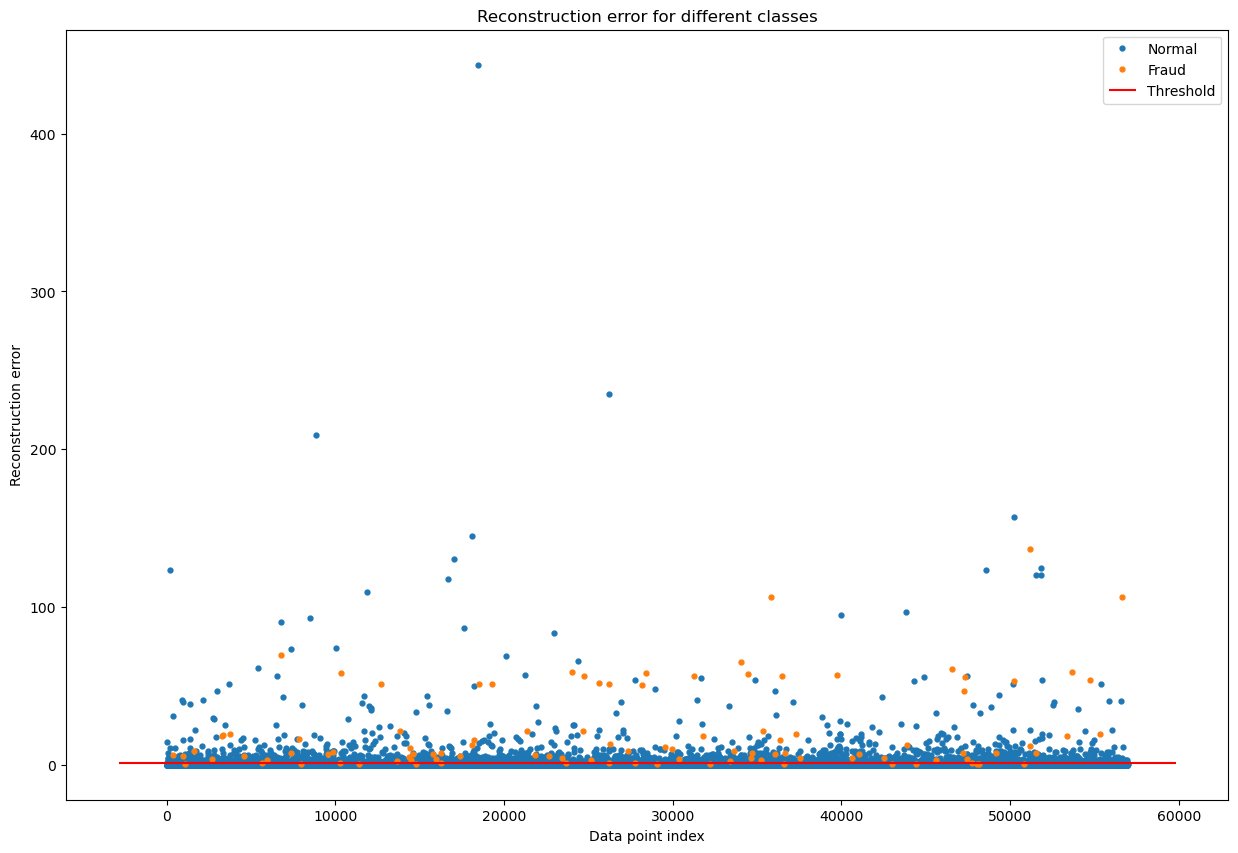

In [ ]:
# scatter plot
threshold = 0.9
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(15, 10))

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


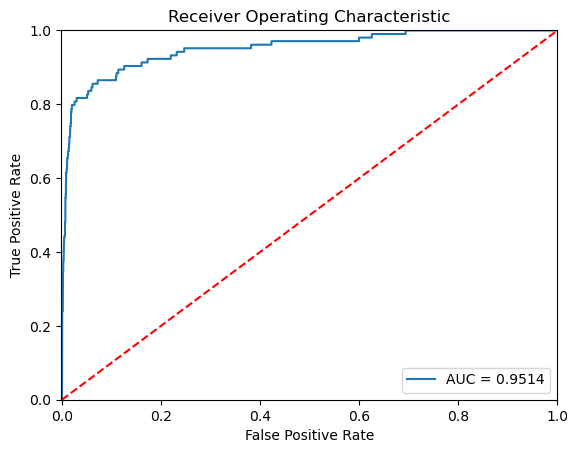

In [ ]:
# ROC
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)
# plot
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();